<a href="https://colab.research.google.com/github/lorrespz/Generative-models/blob/main/VAE_Mathematical_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder from scratch

This notebook is from the following repo

https://github.com/jmtomczak/intro_dgm/blob/main/vaes/

This notebook implements the following mathematical procedure: For a given dataset $D = \{x_n\}^N_{n=1}$, to generate the distribution of $D$, there are 4 steps:
  -  Take $x_n$ and apply the encoder network to get $\mu_\phi(x_n)$ and $\ln\sigma_{\phi}(x_n)$.
  -  Calculate $z_{\phi ,n}$ by applying the reparameterization trick, $z_{\phi,n} = \mu_\phi(x_n) + \sigma_\phi(x_n) \odot \epsilon$,where $\epsilon \sim N(0,I)$.
  - Apply the decoder network to $z_{\phi,n}$ to get the probabilities $\theta(z_{\phi,n})$.
  -  Calculate the objective function ELBO  by plugging in $x_n,z_{\phi,n},\mu_\phi(x_n), \ln\sigma_{\phi}(x_n)$.

In terms of neural networks, we have the following:
  -  The encoder network:
$x \in X^D  \rightarrow Linear(D, 256) \rightarrow LeakyReLU \rightarrow
Linear(256,2M) \rightarrow split \rightarrow \mu \in R^M, log\sigma^2 \in R^M.$
  - The decoder network:
$z \in R^M  \rightarrow  Linear(M, 256) \rightarrow  LeakyReLU \rightarrow
Linear(256, D \times L) \rightarrow  reshape \rightarrow  softmax \rightarrow  \theta \in [0, 1]^{D\times L}$

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [3]:
#!pip install pytorch-model-summary

In [4]:
#from pytorch_model_summary import summary

# Load data

In [5]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

# Define probability distributions

In [6]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p
def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, encoder_net):
        super(Encoder, self).__init__()

        self.encoder = encoder_net

    @staticmethod
    def reparameterization(mu, log_var):
        std = torch.exp(0.5*log_var)

        eps = torch.randn_like(std)

        return mu + std * eps

    def encode(self, x):
        h_e = self.encoder(x)
        mu_e, log_var_e = torch.chunk(h_e, 2, dim=1)

        return mu_e, log_var_e

    def sample(self, x=None, mu_e=None, log_var_e=None):
        if (mu_e is None) and (log_var_e is None):
            mu_e, log_var_e = self.encode(x)
        else:
            if (mu_e is None) or (log_var_e is None):
                raise ValueError('mu and log-var can`t be None!')
        z = self.reparameterization(mu_e, log_var_e)
        return z

    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        if x is not None:
            mu_e, log_var_e = self.encode(x)
            z = self.sample(mu_e=mu_e, log_var_e=log_var_e)
        else:
            if (mu_e is None) or (log_var_e is None) or (z is None):
                raise ValueError('mu, log-var and z can`t be None!')

        return log_normal_diag(z, mu_e, log_var_e)

    def forward(self, x, type='log_prob'):
        assert type in ['encode', 'log_prob'], 'Type could be either encode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x)
        else:
            return self.sample(x)

# Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self, decoder_net, distribution='categorical', num_vals=None):
        super(Decoder, self).__init__()

        self.decoder = decoder_net
        self.distribution = distribution
        self.num_vals=num_vals

    def decode(self, z):
        h_d = self.decoder(z)

        if self.distribution == 'categorical':
            b = h_d.shape[0]
            d = h_d.shape[1]//self.num_vals
            h_d = h_d.view(b, d, self.num_vals)
            mu_d = torch.softmax(h_d, 2)
            return [mu_d]

        elif self.distribution == 'bernoulli':
            mu_d = torch.sigmoid(h_d)
            return [mu_d]

        else:
            raise ValueError('Either `categorical` or `bernoulli`')

    def sample(self, z):
        outs = self.decode(z)

        if self.distribution == 'categorical':
            mu_d = outs[0]
            b = mu_d.shape[0]
            m = mu_d.shape[1]
            mu_d = mu_d.view(mu_d.shape[0], -1, self.num_vals)
            p = mu_d.view(-1, self.num_vals)
            x_new = torch.multinomial(p, num_samples=1).view(b, m)

        elif self.distribution == 'bernoulli':
            mu_d = outs[0]
            x_new = torch.bernoulli(mu_d)

        else:
            raise ValueError('Either `categorical` or `bernoulli`')

        return x_new

    def log_prob(self, x, z):
        outs = self.decode(z)

        if self.distribution == 'categorical':
            mu_d = outs[0]
            log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)

        elif self.distribution == 'bernoulli':
            mu_d = outs[0]
            log_p = log_bernoulli(x, mu_d, reduction='sum', dim=-1)

        else:
            raise ValueError('Either `categorical` or `bernoulli`')

        return log_p

    def forward(self, z, x=None, type='log_prob'):
        assert type in ['decoder', 'log_prob'], 'Type could be either decode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x, z)
        else:
            return self.sample(z)

# Prior

In [9]:
class Prior(nn.Module):
    def __init__(self, L):
        super(Prior, self).__init__()
        self.L = L

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
        return log_standard_normal(z)

# Full VAE

In [10]:
class VAE(nn.Module):
    def __init__(self, encoder_net, decoder_net, num_vals=256, L=16, likelihood_type='categorical'):
        super(VAE, self).__init__()
        self.encoder = Encoder(encoder_net=encoder_net)
        self.decoder = Decoder(distribution=likelihood_type, decoder_net=decoder_net, num_vals=num_vals)
        self.prior = Prior(L=L)

        self.num_vals = num_vals
        self.likelihood_type = likelihood_type

    def forward(self, x, reduction='avg'):
        # encoder
        mu_e, log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)

        # ELBO
        RE = self.decoder.log_prob(x, z)
        KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)).sum(-1)

        if reduction == 'sum':
            return -(RE + KL).sum()
        else:
            return -(RE + KL).mean()

    def sample(self, batch_size=64):
        z = self.prior.sample(batch_size=batch_size)
        return self.decoder.sample(z)

# Utility functions

In [28]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')
    plt.show()
    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')
    plt.show()
    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.show()
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [25]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

# Initialize dataloaders and define parameters

In [13]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'vae'

In [14]:
!ls

results  sample_data


In [15]:
D = 64   # input dimension
L = 16  # number of latents
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [16]:
likelihood_type = 'categorical'

if likelihood_type == 'categorical':
    num_vals = 17
elif likelihood_type == 'bernoulli':
    num_vals = 1

encoder = nn.Sequential(nn.Linear(D, M), nn.LeakyReLU(),
                        nn.Linear(M, M), nn.LeakyReLU(),
                        nn.Linear(M, 2 * L))

decoder = nn.Sequential(nn.Linear(L, M), nn.LeakyReLU(),
                        nn.Linear(M, M), nn.LeakyReLU(),
                        nn.Linear(M, num_vals * D))

prior = torch.distributions.MultivariateNormal(torch.zeros(L), torch.eye(L))
model = VAE(encoder_net=encoder, decoder_net=decoder, num_vals=num_vals, L=L, likelihood_type=likelihood_type)

# Training loop

In [17]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

In [18]:
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, val nll=126.04091099330357
saved!
Epoch: 1, val nll=113.73770368303572
saved!
Epoch: 2, val nll=112.10232561383928
saved!
Epoch: 3, val nll=111.89291782924107
saved!
Epoch: 4, val nll=111.95041643415179
Epoch: 5, val nll=111.32761509486608
saved!
Epoch: 6, val nll=111.53196149553571
Epoch: 7, val nll=111.49953264508929
Epoch: 8, val nll=111.48838030133929
Epoch: 9, val nll=111.36147739955358
Epoch: 10, val nll=111.36245047433036
Epoch: 11, val nll=111.24196219308035
saved!
Epoch: 12, val nll=111.10337751116072
saved!
Epoch: 13, val nll=111.11079171316965
Epoch: 14, val nll=111.23152483258929
Epoch: 15, val nll=111.09098772321428
saved!
Epoch: 16, val nll=110.8620849609375
saved!
Epoch: 17, val nll=110.72084123883928
saved!
Epoch: 18, val nll=110.241982421875
saved!
Epoch: 19, val nll=110.16437918526786
saved!
Epoch: 20, val nll=109.52483119419642
saved!
Epoch: 21, val nll=109.31028250558036
saved!
Epoch: 22, val nll=108.92828752790179
saved!
Epoch: 23, val nll=108.34995326450

In [21]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

FINAL LOSS: nll=96.61864032788031


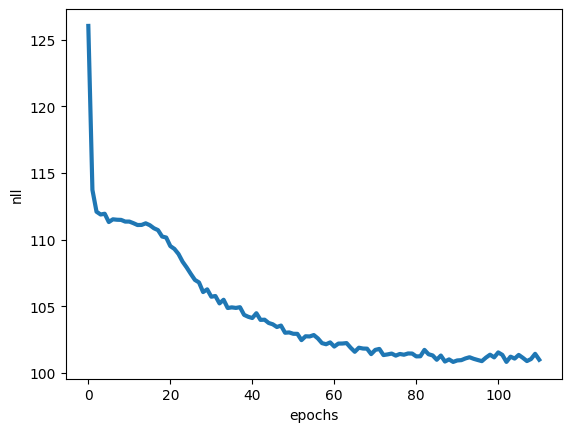

In [29]:
plot_curve(result_dir + name, nll_val)

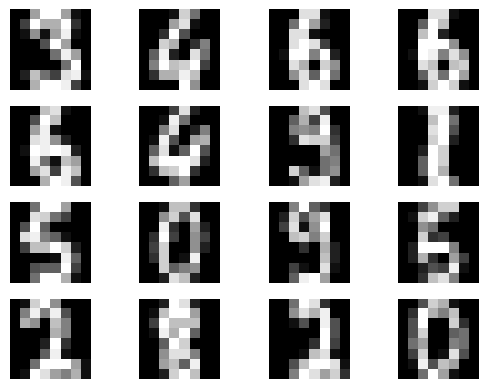

In [27]:
samples_real(result_dir + name, test_loader)

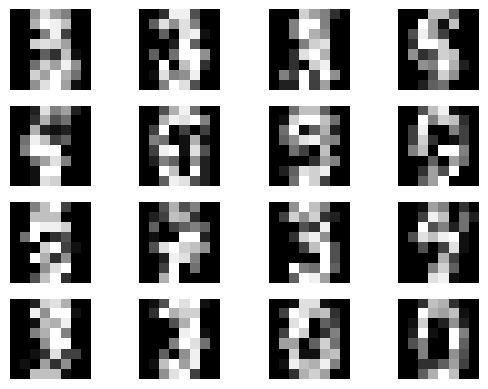

In [30]:
samples_generated(result_dir + name, test_loader)